In [33]:
import array as arr
from BTrees.IIBTree import IIBTree # documentation, https://pythonhosted.org/BTrees/ 
import csv
# import queue    # see https://docs.python.org/3/library/queue.html#module-queue
import math
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
# from matplotlib.collections import Poly3DCollection # https://stackoverflow.com/questions/10599942/drawing-a-rectangle-or-bar-between-two-points-in-a-3d-scatter-plot-in-python-and
# and https://stackoverflow.com/questions/37585340/plotting-3d-polygons-in-python-3
import numpy as np
from trajectory import * # import the trapezoidal trajectory
import time

# interesting/useful websites
# talks about implementing robot simulator: https://www.toptal.com/robotics/programming-a-robot-an-introductory-tutorial  
#    said robot simulator code: https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/supervisor.py

In [34]:
def step(t, dt):
    t = t + dt
    return t

In [63]:
class drawRobot(object):
    def __init__(self):
        self.a = 0
        
    def drawRect(self, q_curr, width_v, length_v):

        xl  = q_curr[0] + width_v / 2  # left x coordinate
        xr  = q_curr[0] - width_v / 2  # right x coordinate

        yf  = q_curr[1] - length_v / 2 # front
        yb  = q_curr[1] + length_v / 2 # back

        verts = []

        xs = [xr, xl, xl, xr, xr]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        ys = [yf, yf, yb, yb, yf]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        z_axis = [0, 0, 0, 0, 0]

        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="blue", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
        
    def drawFrame(self, left_edge, back_edge, front_edge, z_edges_f):
        xl  = left_edge  # back x coordinate
        
        yf  = front_edge # front y coordinate
        yb  = back_edge  # back y coordinate

        zt  = z_edges_f[0]  # top z coordinate
        zb  = z_edges_f[1]  # bottom z coordinate

        verts = []
        
        xs = [xl, xl, xl, xl, xl]
        ys = [yf, yb, yb, yf, yf]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        z_axis = [zt, zt, zb, zb, zt]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        
        verts = [list(zip(xs, ys, z_axis))]
        
        poly = Poly3DCollection(verts, closed = False, alpha=0.25)
        poly.set_facecolor("grey")  # the transparency setting (alpha) is overriden by facecolor otherwise
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
    def drawArmCylinder(self, center_y, center_z, arm_start, arm_end):
        # see second answer https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
        radius = 0.2 # set arbitrarily 
        
        x     = np.linspace(arm_start, arm_end, 3)
        theta = np.linspace(0, 2*np.pi, 3)
        
        theta_grid, x_grid = np.meshgrid(theta, x)
        
        y_grid = radius*np.cos(theta_grid) + center_y
        z_grid = radius*np.sin(theta_grid) + center_z
        
        return x_grid,y_grid,z_grid
            
#                     Xc,Yc,Zc = data_for_cylinder_along_z(0.2,0.2,0.05,0.1)
#                     ax.plot_surface(Xc, Yc, Zc, alpha=0.5)

In [64]:
def vehicleStep(q_curr, v, dt):
    # for now it's constant velocity  
    q_new = np.array([q_curr[0] + v[0]*dt, q_curr[1] + v[1]*dt])
    return q_new

In [65]:
class camera(object):
    def __init__(self, length_v, n_row, frame_height):      
        
        #################### CLASS VARIABLES ####################
        self.width = length_v  # width of camera view, in m
        self.i_lastFruit = 0   # last visited fruit index
        
        # lists of coordinates of picked fruits
        self.x      = []
        self.y      = []
        self.z      = []
        self.t_pick = []        # time when fruit was picked
        
        # list of fruits passed by the vehicle
        self.passed_fruit = []
        
        # Settings for the row
        self.row_n  = n_row     # row number, in one sided-version, lower number means lower on the vehicle
        self.height = frame_height # how high of fruit can this row see

        self.mid_location = (  # tuple used to determine the location of the middle of the row
            self.height/2,
            self.height + self.height/2,
            2*self.height + self.height/2
        )
        
        self.row_mid = self.mid_location[self.row_n] # find the row height for this arm => might not need self

        # calculate the up-down edges of the camera once
        self.view_bot = self.row_mid - self.height / 2 # up-down edges
        self.view_top = self.row_mid + self.height / 2
        
#         print("top:", self.view_top, "bottom:", self.view_bot)
        
        # side edges of the camera
        self.view_min = 0.
        self.view_max = 0.
        
        
        ######################## MODULES ########################
        self.fruitBTree    = IIBTree()
        
               
        
    ######################## FUNCTIONS ########################
    def cameraStep(self, end_row, q_curr, sortedFruit):
        # centered (for now) on the vehicle, perpendicular to data's y-axis
        self.view_min = q_curr - self.width / 2 # side edges
        self.view_max = q_curr + self.width / 2
        
        # fix side end constraints of beginning and end 
        if self.view_min < 0:
            self.view_min = 0

        if self.view_max > end_row:
            self.view_max = end_row
            
        j = self.i_lastFruit # the last fruit that was added (so it repeats less)
            
        # do the same but updating a b-tree instead for better searchability
        while(True):
            if sortedFruit[1,j] > self.view_min and sortedFruit[1,j] < self.view_max:
                # now check vertical edges
                if sortedFruit[2,j] > self.view_bot and sortedFruit[2,j] < self.view_top:
                    # now check if it has been picked before
                    if sortedFruit[3,j] == 0:
                        # convert the y-location into an integer so it can be used as a key, ceiling because it's at the edge
                        # so it can't really be used either way as a goal
                        key = math.ceil(sortedFruit[1,j]*1000) 
                        # add the value to the b-tree
                        self.fruitBTree.update({key:j})
                
            elif sortedFruit[1,j] > self.view_max:
                # no fruit left to add
                break
            j = j + 1
            
        ## delete fruit that's behind the vehicle => put in a seperate set
        # can use it to figure out what speed the vehicle should go => number of fruits left behind?
        if len(self.fruitBTree) > 0:
            self.passedFruit()
            
        self.i_lastFruit = j
        
    
    def passedFruit(self):  
        # removal of all smaller keys than the vehicle's edge from B-Tree
        edge_key  = math.ceil(self.view_min*1000) # edge being passed
        
        try: # if no key exists after the potential key, break out rather than crash the program
            max_key_pop = self.fruitBTree.maxKey(edge_key)
            
            for k in self.fruitBTree.keys():
                if k < max_key_pop:
                    # so it doesn'thave to go through the whole B-Tree
                    self.passed_fruit.append(self.fruitBTree.pop(k))
                else:
                    break         

        except ValueError:
#             print("*** No key smaller than the edge value, broke out of the if statement ***")
            return
            
    
    
    def fruitPicked(self, pointCoord, t):
        self.x.append(float(pointCoord[0]))
        self.y.append(float(pointCoord[1]))
        self.z.append(float(pointCoord[2]))
        self.t_pick.append(float(t))
        
        
    def packFruit(self):
        x_fr = np.array(self.x)
        y_fr = np.array(self.y)
        z_fr = np.array(self.z)
        t    = np.array(self.t_pick)

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        inv_fruit = np.stack([x_fr, y_fr, z_fr, t])
        
        return inv_fruit
        


In [66]:
# def schedule(indexVisFruit):
    # start simple by just popping out the next value (see if we can do this)
#     i_goal = indexVisFruit.get()
#     print(i_goal)

In [67]:
class arm(object):
    def __init__(self, q, n, frame_width, frame_height, row_n, max_vel, max_accel):
        
        ## next level would be for them to be seperate threads with access to the global clock
              
        #################### CLASS VARIABLES ####################
        self.n             = n                           # arm number 
        self.row_n         = row_n                       # which row this arm is located in
        self.q_a           = np.array([q[0],q[1],q[2]])  # arm's location in the world's frame of reference
        self.v_a           = np.array([0.,0.,0.])        # arm's current velocity in the three axis
        
        # list of all locations where arm was
        self.qax           = []
        self.qay           = []
        self.qaz           = []
        
        self.length_f      = 4.5          # how far can it go into trees, in m
        self.width_f       = frame_width  # size of enclosing frame, width in m
        self.height_f      = frame_height # size of enclosing frame, height in m
        
        # frame center coordinates
        self.q_f           = np.array([q[0],q[1],q[2]])  # frame's location in the world's frame of reference
        # edges of the frame
        self.x_edges_f     = np.array([0.,0.])
        self.y_edges_f     = np.array([0.,0.])
        self.z_edges_f     = np.array([0.,0.])
        
        # values for trapezoid trajectory (parameters to play with...)
        self.v_max         = max_vel # 2.  #1.
        self.a_max         = max_accel #10. #10. 
        self.d_max         = max_accel #10. #10.
        
        # can the arm be given a goal, or does it already have one
        self.free          = 1     # start ready to be given a goal 
        self.goal          = np.array([0.,0.,0.])
        self.goal_r        = np.array([0,0,0]) # has the goal been rached at each axis
        self.reached_goals = 0     # how many goals were successfully reached 
        self.goal_index    = 0     # what index did the goal come from 
        
        # Flags
        self.x_move        = 0     # allows the x-dir to start moving
        self.retractFlag   = 0     # checks if the arm is retracting
        
        # following the trapezoidal trajectory
        self.t             = 0.      # time at which the arm will begin moving to the goal
        self.tx            = 0.      # time at which the arm will begin moving in the x-dir
        
        # calculate the error between the final location and given goal coordinates 
        self.error         = np.array([0.,0.,0.])
        
        ######################## MODULES ########################
        self.x = Trajectory(self.v_max, self.a_max, self.d_max)
        self.y = Trajectory(self.v_max, self.a_max, self.d_max)
        self.z = Trajectory(self.v_max, self.a_max, self.d_max)
        
        ################ SELF FUNCTIONS AT INIT #################
        self.initFrame()
        
        
    ######################## FUNCTIONS ########################
    def armStep(self, v_v, dt, t):
        # AAAALLLLL THE AAARMMMSSSSSSSSS
        # v_v is the vehicle's velocity
        # q_curr is the arm's current location within the world frame 
        q_curr      = np.array([self.q_a[0],self.q_a[1],self.q_a[2]])

        goal_time   = t - self.t      # time since the y-z self timer was started
        goal_time_x = t - self.tx     # time since the x self timer was started => not updating correctly
        
        can_reach   = 0               # start with the possibility that a fruit cannot be reached
        epsilon     = 0.001           # allowable error when reaching fruit 
    
        # move along with the vehicle
        self.moveFrame(v_v, dt)       # start with the frame
        
        # check if fruit can still be reached according to frame's location 
        can_reach   = self.reachable()
        
        if can_reach == 1:
            # at the moment trying to cancel the vehicle's velocity/movement's effect on the arms by subtracting it
            # in the y-axis:
            self.calcYVel(goal_time, v_v)
            # in the z-axis:  
            self.calcZVel(goal_time)  # not affected by the vehicle's velocity

            # if both y and z goal locations reached, start moving in the x-dir to grab the fruit
            if self.goal_r[1] == 1 and self.goal_r[2] == 1:
                # check that it's the first time this has been reached since a new goal was given
                if self.tx == 0.:        
                    self.tx     = t   # start time for the new timer for x
                    goal_time_x = 0.  # restart the timer for x
                    self.x_move = 1   # allow movement in the x-direction

            if self.x_move == 1: 
                self.calcXVel(goal_time_x, v_v)
              
        elif can_reach == 0:
            # set these at zero and check if arm has to be retracted
            self.v_a[1] = 0
            self.v_a[2] = 0
            if self.retractFlag == 1: 
#                 print("THE ARRRMMMMMMSSSSS")
#                 print("THEY RETRACT?", self.retractFlag)
#                 print("GOOOOAL", goal_time_x)
                self.calcXVel(goal_time_x, v_v)
#                 print("AND AFTER?", self.retractFlag)
                if self.goal[0] != 1 or self.goal[1] != 1 or self.goal[2] != 1:
                    # if it's retracting before it reached it's goal, then the fruit was not picked
                    fruit.sortedFruit[3,self.goal_index] = 0
                    print("Fruit skipped")
        
        self.q_a[0] = q_curr[0] + self.v_a[0]*dt + v_v[0]*dt # coordinate affected by the vehicle's speed (need to change to reflect the axis)
        self.q_a[1] = q_curr[1] + self.v_a[1]*dt + v_v[1]*dt # coordinate affected by the vehicle's speed
        self.q_a[2] = q_curr[2] + self.v_a[2]*dt 
        
        # stop the arm from extending backwards beyond the back of the frame
        if self.q_a[0] < self.q_f[0]:
            self.q_a[0] = self.q_f[0]
        
        # update the location history (for plotting :) ) 
        self.qax.append(float(self.q_a[0]))
        self.qay.append(float(self.q_a[1]))
        self.qaz.append(float(self.q_a[2]))
        
#         if self.q_a[0] < self.q_f[0]-0.001:  
#             print("")
#             print("ARM:", self.n, "ROW:", self.row_n)
#             print("edges in X:", self.x_edges_f, "edges in Y:", self.y_edges_f, "edges in Z:", self.z_edges_f)

#             print("goal:         {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
#             print("arm location: {0:.4f}".format(self.q_a[0]), " {0:.4f}".format(self.q_a[1]), " {0:.4f}".format(self.q_a[2]))

#         print("")
#         print("Goals reached:", self.goal_r)
#         print("retracting:", self.retractFlag)
#         print("can it reach?:", can_reach)
#         print("")
 
        # check if the goal was reached within +/- some error ((correct and fixed, don't touch unless proof of mistake))
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1):
            if ((self.q_a[0] > (self.goal[0]-epsilon) and self.q_a[0] < (self.goal[0]+epsilon)) and
                (self.q_a[1] > (self.goal[1]-epsilon) and self.q_a[1] < (self.goal[1]+epsilon)) and
                (self.q_a[2] > (self.goal[2]-epsilon) and self.q_a[2] < (self.goal[2]+epsilon))):
                # find a better way to do this?
                self.reached_goals += 1
#                 print("GOAL REACHED")
                # "pick" the fruit
                row_picture[self.row_n].fruitPicked(self.q_a, t)
        
        # if goal has been reached or the fruit cannot be reached, set free to one so a new goal can be given
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1) or can_reach == 0:
            # retract the arm if needed 
            if (self.q_a[0] > self.q_f[0]+epsilon or self.q_a[0] < self.q_f[0]-epsilon) and self.retractFlag == 0: # not equal
                self.retract()
                # restart the x timers
                self.tx     = t      # start time for the new timer for x
                goal_time_x = 0.
                
            elif self.retractFlag == 0:
                self.tx        = 0.
                self.free      = 1 
                self.x_move    = 0
                # restart the goal reached values for all axis when new goal is given
                self.goal_r[0] = 0
                self.goal_r[1] = 0
                self.goal_r[2] = 0
        
        return self.q_a
    

    def retract(self):
        # retracts the arm 
        self.x.adjInit(self.q_a[0], 0)
        self.x.noJerkProfile(self.q_a[0], self.q_f[0], self.x.v0, self.v_max, self.a_max, self.d_max)
        
#         if self.q_a[0] < self.q_f[0]-0.001:
#             print(" ")
#             print("RETRACTING")
#             print("ARM:", self.n, "ROW:", self.row_n)
#             print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)      
#             print(" ")
#             print("goal:         {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
        
        self.retractFlag = 1
    
    
    def setGoal(self, goal, t):
        self.free = 0
        self.goal = goal
        
        self.x.adjInit(self.q_a[0], 0) # init each axis with current location and velocity (will need velocity at some point)   
        self.y.adjInit(self.q_a[1], 0) 
        self.z.adjInit(self.q_a[2], 0)
        
        self.trapTimes()
            
        # maybe start time here? => evalulate how that could change things once in real time
        self.t = t
        
        
    def trapTimes(self):
        # get trapezoidal times
        self.x.noJerkProfile(self.x.q0, self.goal[0], self.x.v0, self.v_max, self.a_max, self.d_max) 
        self.y.noJerkProfile(self.y.q0, self.goal[1], self.y.v0, self.v_max, self.a_max, self.d_max)  
        self.z.noJerkProfile(self.z.q0, self.goal[2], self.z.v0, self.v_max, self.a_max, self.d_max)  
        
#         print(" ")
#         print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)
#         print("Y-axis, Ta:", self.y.Ta, "Tv:", self.y.Tv, "Td:", self.y.Td)
#         print("Z-axis, Ta:", self.z.Ta, "Tv:", self.z.Tv, "Td:", self.z.Td) 
#         print(" ")
#         print("reached values, X:", self.x.vr, self.x.ar, self.x.dr)
#         print("reached values, Y:", self.y.vr, self.y.ar, self.y.dr)
#         print("reached values, Z:", self.z.vr, self.z.ar, self.z.dr)        
#         print(" ")
        # as more arms are added, these might need to be made internal to the object
       
    
    def initFrame(self):
        # calculate the edges of the frame
        # the x-dir edge is more of a limit on the extension capabilities of the arm. so it's not symetrical
        self.x_edges_f[0] = self.q_f[0]
        self.x_edges_f[1] = self.q_f[0] + self.length_f
        
        # the y-dir edge moves along with the vehicle's movement
        self.y_edges_f[0] = self.q_f[1] + self.width_f / 2
        self.y_edges_f[1] = self.q_f[1] - self.width_f / 2
        
        # the height will stay constant throughout
        self.z_edges_f[0] = self.q_f[2] + self.height_f / 2
        self.z_edges_f[1] = self.q_f[2] - self.height_f / 2
    
    
    def moveFrame(self, v_v, dt):
        x_coor = self.q_f[0]
        y_coor = self.q_f[1]
        
        left_edge  = self.x_edges_f[0]
        right_edge = self.x_edges_f[1]
        front_edge = self.y_edges_f[0]
        back_edge  = self.y_edges_f[1]
        
        # move the center point as the vehicle moves
        self.q_f[0] = x_coor + v_v[0]*dt
        self.q_f[1] = y_coor + v_v[1]*dt
        
        # move the edges
        self.x_edges_f[0] = left_edge + v_v[0]*dt
        self.x_edges_f[1] = right_edge + v_v[0]*dt
        
        self.y_edges_f[0] = front_edge + v_v[1]*dt
        self.y_edges_f[1] = back_edge + v_v[1]*dt
       
    
    def reachable(self):
        # check if the fruit is reachable now or in the "future" => actually, should use trapezoidal calc
        # to see if it can reach. ==> not true. Because the vehicle's speed will be variable, these calculations 
        # will very likely be wrong
        
        if self.goal[0] < self.x_edges_f[1] and self.goal[1] > self.y_edges_f[1]:
            # check if the goal is behind the back edges of the frame or over the extension range of the arm
            # don't need to check the y frame because no goals that pass it can be given (already limited by camera object)
            return 1

        else:
            return 0 
        
    
    def calcXVel(self, goal_time_x, v_v):
        if goal_time_x <= self.x.Ta:
            self.v_a[0] = self.x.v0 + self.x.ar*goal_time_x - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv:
            self.v_a[0] = self.x.vr - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv + self.x.Td:
            self.v_a[0] = self.x.vr - self.x.dr*(goal_time_x - (self.x.Ta + self.x.Tv)) - v_v[0]
        
        else:
            self.v_a[0] = -v_v[0] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[0] = 1
            self.retractFlag = 0
            
    
    def calcYVel(self, goal_time, v_v):
        if goal_time <= self.y.Ta:
            self.v_a[1] = self.y.v0 + self.y.ar*goal_time - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv:
            self.v_a[1] = self.y.vr  - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv + self.y.Td:
            self.v_a[1] = self.y.vr - self.y.dr*(goal_time - (self.y.Ta + self.y.Tv))  - v_v[1]
        
        else:
            self.v_a[1] = -v_v[1] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[1] = 1
            
            
    def calcZVel(self, goal_time):
        if goal_time <= self.z.Ta:
            self.v_a[2] = self.z.v0 + self.z.ar*goal_time

        elif goal_time <= self.z.Ta + self.z.Tv:
            self.v_a[2] = self.z.vr

        elif goal_time <= self.z.Ta + self.z.Tv + self.z.Td:
            self.v_a[2] = self.z.vr - self.z.dr*(goal_time - (self.z.Ta + self.z.Tv))
        else:
            self.v_a[2] = 0.
            self.goal_r[2] = 1
        
        
    def calcError(self):
        # Calculate the error between the final location and the given goal coordinates for the arm
        self.error[0] = (self.goal[0] - self.q_a[0]) / self.goal[0]
        self.error[1] = (self.goal[1] - self.q_a[1]) / self.goal[1]
        self.error[2] = (self.goal[2] - self.q_a[2]) / self.goal[2]
    

In [68]:
class csvRead(object):
    def __init__(self):
        #################### CLASS VARIABLES ####################
        
        
        # open CSV file and populate fruits on grid
        x_fr = []
        y_fr = []
        z_fr = []

        # with open('Applestotheleft.csv', newline='') as csvfile:
        #     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        #     for row in spamreader:
        #         x_fr.append(float(row[0]))
        #         y_fr.append(float(row[1]))
        #         z_fr.append(float(row[2]))

        with open('Applestotheright.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in spamreader:
                x_fr.append(float(row[0]))
                y_fr.append(float(row[1]))
                z_fr.append(float(row[2]))

        self.x_fruit = np.array(x_fr)
        self.y_fruit = np.array(y_fr)
        self.z_fruit = np.array(z_fr)
        picked  = np.zeros(len(self.x_fruit))

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        fruit = np.stack([x_fr, y_fr, self.z_fruit, picked])

        rowIndex = 1 # sort based on y-axis
        self.sortedFruit = fruit[ :, fruit[rowIndex].argsort()]

#         return sortedFruit


In [69]:
# init environment
noise = 0.     # for when it becomes stochastic
end_row = 15.  # end of the row
t = []         # 'global' time
t_new = 0.
dt = 0.01      # 'global' time step size
runs = 0

fruit = csvRead()

dr = drawRobot()

In [70]:
# init vehicle
num_arms     = 3                 # set number of arms on robot, will determine the length of the robot (for now)
### above might turn into number of arms per row, not per robot?
num_row_arms = 3                 # set the number of rows of arms. Getting it ready to add when one row works
frame_width  = 3.                # set the arm's frame's width along y-axis 
frame_height = 3.                # set the height of the arm's frame

width_v = 1.                     # vehicle width (x-dir, parallel to arms going into canopy)
length_v = frame_width*num_arms  # vehicle length (y-dir parallel to row of trees)

q_v = np.array([6.3,9.])         # starting location
v_v = np.array([0.,0.01])       # in m, constant velocity   => got almost 100% fruit at 0.007m/s with 0.73s/fruit (too slow)

qv0 = []
qv1 = []

In [71]:
# init camera, one for each row!
row_picture = []

for rows in range(num_row_arms):
    p = camera(length_v, rows, frame_height)
    row_picture.append(p)
    
# picture = camera(length_v)

In [72]:
# init scheduler
goal = np.zeros(3) # does this go here?

In [73]:
# init arms
# get 0th arm's center point on y-axis
arm0start_y = q_v[1] - (length_v - frame_width)/2
# set location for 0th arm
q_a     = np.array([q_v[0],arm0start_y,4]) # location of arm in vehicle frame? => need to figure out how to set these when there are >1 arms
q_a_new = np.array([0.,0.,0.]) 

max_v = 1.
max_a = 10.

arm_extension = 0.75 / (num_row_arms-1) # divide by num of arms because it's going to be inverted diagonal vs row num

a = np.ndarray((num_row_arms,num_arms), dtype=object)

# for each row
for rows in range(num_row_arms):       
    # initialize the arms in a list
    for count in range(num_arms):      
        # calculate where each new arm should go
        # fruit's in a diagonal, so get the bottom arms closer to the fruit
        # the 0.3 is the zero starting point since it will never be exactly zero if they're extending cylinders
        q_a_new[0] = q_a[0] + 0.3 + ((num_row_arms-1)*arm_extension - arm_extension*rows)  
        q_a_new[1] = q_a[1] + frame_width*count  # place it next to the previous arm
        q_a_new[2] = row_picture[rows].row_mid   # place it in the already calculated middle of the row
        # initialize the new arm 
        x = arm(q_a_new, count, frame_width, frame_height, rows, max_v, max_a)
        # add the arm to the a-list     
        a[rows,count] = x
        
    
## the different levels of arms might start at different distances from the frame (cause fruit farther away)
# maybe have a configuration file that would initialize the arms 

# for plotting
left_edge  = []
right_edge = []
front_edge = []
back_edge  = []


In [74]:
## start timer to see how long code takes to execute
start_time = time.time()

##### while loooop!
while(q_v[1] < end_row):
    # env.step
    t_new = step(t_new, dt)
    t.append(float(t_new))
    
    
    # vehicle.step 
    q_v = vehicleStep(q_v, v_v, dt) # calculate "instantaneous" location
    
    
    # env.obs / camera... FLASH!
    for rows in range(num_row_arms):
        row_picture[rows].cameraStep(end_row, q_v[1], fruit.sortedFruit) # resulting in a B-Tree of index/coordinates in world frame  
    
    
    if (noise == 1):
        # add some noissse! (to the fruit locations)
        noise = 0 # but not right now
    
    ## create a function/class of the greedy assignment algorithm 
    # more general fruit to arm assignment (do more of the fruit per arm at the same time)
    
    # schedule
    # for each row
    for rows in range(num_row_arms):
        # check if there are any arms that are free 
        for arm_free in range(num_arms):
            if a[rows,arm_free].free == 1 and len(row_picture[rows].fruitBTree) > 0:
                # get the location of this arm's back edge and convert to integer to get a value to compare keys
                
                potential_key = math.floor(a[rows,arm_free].y_edges_f[1]*1000) #+2
                # find a value in the B-tree that fits it's location 
                try: # if no key exists after the potential key, break out rather than crash the program
                    key = row_picture[rows].fruitBTree.minKey(potential_key)
                    index = row_picture[rows].fruitBTree[key]
                    
                    # check that the goal does not pass the front part of the frame
                    if fruit.sortedFruit[1,index] < a[rows,arm_free].y_edges_f[0]+1:
                        # choose the first fruit as a goal to be given to the arm
                        goal_new = row_picture[rows].fruitBTree.pop(key)
                        # set the index's fruit as picked
                        fruit.sortedFruit[3,goal_new] = 1
                        # give the arm the index so that it can set it back to 0 if it does not reach it
                        a[rows,arm_free].goal_index = goal_new
                        # set the new goal
                        a[rows,arm_free].setGoal(fruit.sortedFruit[0:3,goal_new], t_new)
                        ### make sure there are available goals left in the b-tree at some point
                    
                except ValueError:
                    print("*** No value came up, broke out of the if statement ***")
                    break

    
    # have each arm take a step
    for rows in range(num_row_arms):
        for arm2step in range(num_arms):
            q_a = a[rows,arm2step].armStep(v_v, dt, t_new)
    
    # plotting data     
    qv0.append(float(q_v[0]))
    qv1.append(float(q_v[1]))
    
    left_edge.append(float(q_v[0]))  # set at the center of the vehicle in case the arm is set as diagonal to rach farther fruit
    front_edge.append(float(a[0,0].y_edges_f[0]))
    back_edge.append(float(a[0,0].y_edges_f[1]))
               
    runs+=1

    
prog_time = time.time() - start_time

start, end, start velocity: 7.35 9.8678696059 0
start, end, start velocity: 6.0 5.3231695488 0
start, end, start velocity: 1.5 1.1919865482 0
start, end, start velocity: 7.35 9.9191284757 0
start, end, start velocity: 9.0 7.5732524703 0
start, end, start velocity: 1.5 1.4549112491 0
start, end, start velocity: 7.35 9.0836432909 0
start, end, start velocity: 12.0 10.794768294 0
start, end, start velocity: 1.5 0.9577824011 0
start, end, start velocity: 6.975 7.8880462924 0
start, end, start velocity: 6.0 5.9278863172 0
start, end, start velocity: 4.5 4.2075675354 0
start, end, start velocity: 6.975 8.2155859972 0
start, end, start velocity: 9.0 7.5099152899 0
start, end, start velocity: 4.5 3.7314053709 0
start, end, start velocity: 6.975 7.7962720949 0
start, end, start velocity: 12.0 10.5610279055 0
start, end, start velocity: 4.5 4.0949260327 0
start, end, start velocity: 6.6 7.5979936552 0
start, end, start velocity: 6.0 6.0434705216 0
start, end, start velocity: 7.5 6.1161441163 0
s

start, end, start velocity: 8.384419397300004 7.35 0
start, end, start velocity: 6.6 7.1655016583 0
start, end, start velocity: 6.207639791640485 6.2865057933 0
start, end, start velocity: 7.727165289800002 7.8676352634 0
start, end, start velocity: 7.241754719800003 6.6 0
start, end, start velocity: 6.975 7.9305535105 0
start, end, start velocity: 6.037698615468678 6.0576238249 0
start, end, start velocity: 4.266017760499997 4.0423241028 0
start, end, start velocity: 7.35 8.4426428431 0
start, end, start velocity: 10.936036125099996 11.0947797883 0
start, end, start velocity: 2.4748295433000234 2.3261574071 0
start, end, start velocity: 7.905122069400003 6.975 0
start, end, start velocity: 6.6 6.8323500587 0
start, end, start velocity: 7.69411860695972 7.6996549338 0
start, end, start velocity: 7.712397479800003 7.1300359896 0
start, end, start velocity: 6.975 8.678124188 0
start, end, start velocity: 7.611816725783919 7.7050836186 0
start, end, start velocity: 3.4941797118999984 4.26

start, end, start velocity: 6.600000000000156 7.7667841274 0
start, end, start velocity: 11.828910815711916 11.8454765652 0
start, end, start velocity: 8.575010900373359 7.3349015093 0
start, end, start velocity: 6.600000000000128 7.1252653382 0
start, end, start velocity: 6.493040193853252 6.497171205 0
start, end, start velocity: 7.7084894174999965 8.2089553121 0
start, end, start velocity: 6.6000000000001995 7.6046578614 0
start, end, start velocity: 7.738222767648162 7.7506390277 0
start, end, start velocity: 7.858148206099998 6.9302881467 0
start, end, start velocity: 6.975000000000078 7.9028977053 0
start, end, start velocity: 6.164720677457029 6.1760569125 0
start, end, start velocity: 5.509165249899969 3.8238515345 0
start, end, start velocity: 6.975000000000275 8.1398842161 0
start, end, start velocity: 7.825937186799997 7.8724415143 0
start, end, start velocity: 3.5148481656999984 4.6588623813 0
start, end, start velocity: 7.856908574699844 6.975 0
start, end, start velocity:

start, end, start velocity: 6.9750000000002 8.1386618985 0
start, end, start velocity: 10.845990556199975 11.077697691 0
start, end, start velocity: 3.6920502305999827 3.488492627 0
start, end, start velocity: 7.101102564799912 6.6 0
start, end, start velocity: 7.068017263299919 6.6 0
start, end, start velocity: 6.600000000000088 6.9357649548 0
start, end, start velocity: 7.404854505556451 7.4376066872 0
start, end, start velocity: 7.034816701885729 7.3155241482 0
start, end, start velocity: 9.89938428789955 7.35 0
start, end, start velocity: 6.975000000000181 8.047145143 0
start, end, start velocity: 6.403668441499968 6.4180592872 0
start, end, start velocity: 5.060587374699801 5.0428129249 0
start, end, start velocity: 6.6000000000000805 6.4259301825 0
start, end, start velocity: 7.792210147140994 7.8478658145 0
start, end, start velocity: 8.575295435402237 7.6788327735 0
start, end, start velocity: 7.350000000000529 10.3246181674 0
start, end, start velocity: 5.509629499002524 5.570

start, end, start velocity: 6.8391287341000435 6.6 0
start, end, start velocity: 8.395186781100255 6.975 0
start, end, start velocity: 7.169172397200102 6.6 0
start, end, start velocity: 6.6 7.4687730652 0
start, end, start velocity: 8.239405661187174 8.247668253 0
start, end, start velocity: 6.407085128700057 6.2951909681 0
start, end, start velocity: 6.975 8.538211025 0
start, end, start velocity: 8.178220978895228 8.2494742894 0
start, end, start velocity: 3.9845033089999258 4.8894142184 0
start, end, start velocity: 7.405416173100145 6.6 0
start, end, start velocity: 6.6 7.8244589915 0
start, end, start velocity: 12.086085059256222 12.1042154242 0
start, end, start velocity: 6.0009033346995455 6.2763898165 0
start, end, start velocity: 7.35 9.5534861016 0
start, end, start velocity: 5.605526523967476 5.6694852492 0
start, end, start velocity: 2.6322168487000606 2.3990189407 0
start, end, start velocity: 7.468773065200155 6.6 0
start, end, start velocity: 6.975 8.5783843692 0
start,

start, end, start velocity: 7.720446692899694 6.6 0
start, end, start velocity: 6.975000000000357 7.9472895566 0
start, end, start velocity: 11.53225215101351 11.5374681612 0
start, end, start velocity: 5.23989004149993 5.2712000339 0
start, end, start velocity: 8.76873507799964 7.35 0
start, end, start velocity: 7.377488220299586 6.6 0
start, end, start velocity: 9.029812754499584 7.35 0
start, end, start velocity: 7.689373773699421 6.6 0
start, end, start velocity: 6.6000000000004135 7.6944416079 0
start, end, start velocity: 12.269093531835034 12.2727542115 0
start, end, start velocity: 7.514462361350096 7.2351406646 0
start, end, start velocity: 6.6000000000006 6.9402778762 0
start, end, start velocity: 8.75176284949209 8.8052490879 0
start, end, start velocity: 7.11614525960006 7.9949785729 0
start, end, start velocity: 7.947289556599481 6.975 0
start, end, start velocity: 7.611836513699662 6.975 0
start, end, start velocity: 7.350000000000755 8.2585472118 0
start, end, start velo

Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
start, end, start velocity: 6.975000000000318 7.8452567893 0
start, end, start velocity: 7.129613739699934 7.1631933393 0
start, end, start velocity: 4.848637506299176 4.792741176 0
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
start, end, start velocity: 7.350000000000179 9.333058669 0
start, end, start velocity: 8.342376778378878 8.520953055 0
start, end, start velocity: 1.3299508112997598 1.3094137722 0
start, end, start velocity: 6.600000000000579 7.1475465094 0
start, end, start velocity: 12.426668473134963 12.4857757745 0
start, end, start velocity: 7.382584600899357 6.9892187133 0
start, end, start velocity: 7.591578067599469 6.6 0
start, end, start velocity: 7.3500000000006 8.4523149408 0
start, end, start velocity: 11.642992312650472 11.6668870265 0
start, end, start velocity: 2.630651577

start, end, start velocity: 8.070661851199418 6.975 0
start, end, start velocity: 7.399537997199577 6.6 0
start, end, start velocity: 8.577189272499144 6.975 0
start, end, start velocity: 7.461352271099539 6.6 0
start, end, start velocity: 6.600000000000424 6.778988858 0
start, end, start velocity: 9.460942357945898 9.4881968309 0
start, end, start velocity: 7.546887672399368 6.0790498136 0
start, end, start velocity: 6.975000000000797 8.2913312067 0
start, end, start velocity: 11.850503754788898 11.8671078268 0
start, end, start velocity: 4.160657192300148 4.2585087014 0
start, end, start velocity: 6.975000000000584 7.9208771576 0
start, end, start velocity: 7.3074274678234 7.3081255577 0
start, end, start velocity: 3.2188412289004615 3.2540050919 0
start, end, start velocity: 9.480727382098863 7.35 0
start, end, start velocity: 6.6000000000004615 7.1237227864 0
start, end, start velocity: 12.679706591467685 12.6869023151 0
start, end, start velocity: 8.520623848299191 6.9626934253 0


start, end, start velocity: 7.350000000000946 8.650867249 0
start, end, start velocity: 11.74679581901844 11.7718383878 0
start, end, start velocity: 2.100792018999944 2.4370323751 0
start, end, start velocity: 6.975000000000605 8.5941126744 0
start, end, start velocity: 8.61981912503323 8.6275245988 0
start, end, start velocity: 4.916596665689472 3.4717857262 0
start, end, start velocity: 7.119668133399726 6.6 0
start, end, start velocity: 7.85820873819933 6.6 0
start, end, start velocity: 6.600000000000275 7.0828207089 0
start, end, start velocity: 12.823358089161585 12.8563693705 0
start, end, start velocity: 6.468572969300292 8.515435209 0
start, end, start velocity: 8.12384415199939 6.975 0
start, end, start velocity: 7.350000000000994 9.7317064357 0
start, end, start velocity: 9.025438837199893 9.0735489546 0
start, end, start velocity: 1.7554104063005904 0.7343667889 0
start, end, start velocity: 7.350000000000925 8.8259362025 0
start, end, start velocity: 6.203433354465265 6.23

start, end, start velocity: 8.907073301599759 6.975 0
start, end, start velocity: 7.196781488600198 6.975 0
start, end, start velocity: 6.975 7.852242141 0
start, end, start velocity: 11.978333236269073 11.9842215397 0
start, end, start velocity: 5.892333893200232 4.6443445353 0
start, end, start velocity: 9.775247051301157 7.35 0
start, end, start velocity: 7.35 8.4168977659 0
start, end, start velocity: 11.874402078316445 11.9753801525 0
start, end, start velocity: 2.302524422781888 2.1370069262 0
start, end, start velocity: 9.087696281801538 7.35 0
start, end, start velocity: 6.975 8.6555841198 0
start, end, start velocity: 8.850021268156244 8.9260731197 0
start, end, start velocity: 3.3241071807005573 3.3476561709 0
start, end, start velocity: 7.34129781200066 6.6 0
start, end, start velocity: 8.416897765900943 7.35 0
start, end, start velocity: 7.852242141000774 6.975 0
start, end, start velocity: 9.186595815901965 6.975 0
start, end, start velocity: 6.6 7.5296601035 0
start, end,

start, end, start velocity: 6.975 7.7479138908 0
start, end, start velocity: 9.543794882202318 9.5528395555 0
start, end, start velocity: 5.606488530501264 5.170858349 0
start, end, start velocity: 6.6 7.2119444179 0
start, end, start velocity: 13.57051889350011 13.5892076567 0
start, end, start velocity: 7.9646129309014855 8.396518526 0
start, end, start velocity: 6.975 6.8845510608 0
start, end, start velocity: 12.296763150900103 12.3190344506 0
start, end, start velocity: 5.961797304801069 5.9335115991 0
start, end, start velocity: 7.35 9.1666264758 0
start, end, start velocity: 12.222213637587407 12.2457416985 0
start, end, start velocity: 1.350163927787109 0.6161199307 0
start, end, start velocity: 6.975 7.4602609272 0
start, end, start velocity: 9.550584247000083 9.5849380931 0
start, end, start velocity: 5.837219525800819 5.3888554138 0
start, end, start velocity: 6.975 7.5905013667 0
start, end, start velocity: 12.31895562879639 12.3521057994 0
start, end, start velocity: 5.933

start, end, start velocity: 7.79630131840106 6.6 0
start, end, start velocity: 7.35 8.4514139563 0
start, end, start velocity: 12.377637892622628 12.4279317959 0
start, end, start velocity: 0.4898433096991899 1.224675426 0
start, end, start velocity: 8.98315073270145 7.35 0
start, end, start velocity: 6.6 7.26355799 0
start, end, start velocity: 13.68812111409689 13.7187933525 0
start, end, start velocity: 7.5533608934008285 8.1114479924 0
start, end, start velocity: 8.471406262201327 6.975 0
start, end, start velocity: 7.331385340200313 6.975 0
start, end, start velocity: 9.641712242602036 7.35 0
start, end, start velocity: 6.975 8.4322782678 0
start, end, start velocity: 10.211513453700299 10.291801695 0
start, end, start velocity: 5.234063303999358 3.7583417765 0
start, end, start velocity: 6.975 7.4584505729 0
start, end, start velocity: 10.287715292683055 10.3044539311 0
start, end, start velocity: 5.078083982401227 4.3299734526 0
start, end, start velocity: 8.45141395630098 7.35 

start, end, start velocity: 7.35 8.5087982439 0
start, end, start velocity: 10.12810433810011 10.1473676839 0
start, end, start velocity: 1.3138856537998727 1.8733413756 0
start, end, start velocity: 6.6 7.4597027399 0
start, end, start velocity: 14.330019475979256 14.3534349701 0
start, end, start velocity: 7.535909028400162 7.3626382892 0
start, end, start velocity: 7.572722380100526 6.975 0
start, end, start velocity: 7.459702739900758 6.6 0
start, end, start velocity: 6.975 7.8067666115 0
start, end, start velocity: 13.030367299127679 13.1161500123 0
start, end, start velocity: 5.053731682600704 5.4753208867 0
start, end, start velocity: 9.17954475820162 7.35 0
start, end, start velocity: 8.508798243901023 7.35 0
start, end, start velocity: 9.43997532530185 7.35 0
start, end, start velocity: 6.6 7.1453336752 0
start, end, start velocity: 14.353409034895167 14.3593277263 0
start, end, start velocity: 7.362638289199847 6.6151614772 0
start, end, start velocity: 8.492313194301342 6.97

start, end, start velocity: 7.35 8.761382837 0
start, end, start velocity: 10.36539842502757 10.3801915062 0
start, end, start velocity: 0.49819284119903506 0.5673132055 0
start, end, start velocity: 6.6 7.7977479748 0
start, end, start velocity: 14.570419693290946 14.5787882182 0
start, end, start velocity: 6.886924999599456 6.7710374216 0
start, end, start velocity: 8.781725324101274 7.35 0
start, end, start velocity: 9.62018748720202 7.35 0
start, end, start velocity: 9.027578127801824 6.975 0
start, end, start velocity: 7.797747974801059 6.6 0
start, end, start velocity: 7.35 8.7708383555 0
start, end, start velocity: 12.990416568266754 13.0156303582 0
start, end, start velocity: 2.4091096162999093 2.4158438463 0
start, end, start velocity: 8.761382837001253 7.35 0
start, end, start velocity: 7.481684167000447 6.975 0
start, end, start velocity: 6.6 6.907529075 0
start, end, start velocity: 14.578776734995284 14.5870276142 0
start, end, start velocity: 6.7710374215999 7.9017935757 

start, end, start velocity: 9.261699798301699 7.35 0
start, end, start velocity: 7.35 9.2459756858 0
start, end, start velocity: 13.63585542265777 13.669738697 0
start, end, start velocity: 1.3326126550562405 0.944099427 0
start, end, start velocity: 6.975 7.977262027 0
start, end, start velocity: 13.838996995300137 13.9275237564 0
start, end, start velocity: 4.311349706899076 4.6268599112 0
start, end, start velocity: 7.918798691901166 6.6 0
start, end, start velocity: 7.97726202700089 6.975 0
start, end, start velocity: 7.35 8.3409462398 0
start, end, start velocity: 13.664183626753141 13.6923491643 0
start, end, start velocity: 2.271067757600101 2.9197225372 0
start, end, start velocity: 9.245975685801682 7.35 0
start, end, start velocity: 6.975 9.0026502443 0
start, end, start velocity: 13.927356584920503 13.9293467512 0
start, end, start velocity: 4.6268599112002775 3.1107063537 0
start, end, start velocity: 6.6 7.8780318357 0
start, end, start velocity: 14.785934619410206 14.7969

start, end, start velocity: 6.975 7.3869473526 0
start, end, start velocity: 14.279089549676668 14.3222100199 0
start, end, start velocity: 4.977383292800802 4.9128888124 0
start, end, start velocity: 7.719319617500659 6.975 0
start, end, start velocity: 7.386947352600366 6.975 0
start, end, start velocity: 6.975 8.1652535807 0
start, end, start velocity: 14.322022199827638 14.3695778483 0
start, end, start velocity: 4.912889763848484 5.2079644787 0
start, end, start velocity: 6.975 7.5009433044 0
start, end, start velocity: 14.28307157956682 14.3998258454 0
start, end, start velocity: 4.526571399444707 5.045250927 0
start, end, start velocity: 9.112877915201567 7.35 0
start, end, start velocity: 9.35250849440178 7.35 0
start, end, start velocity: 7.500943304400463 6.975 0
start, end, start velocity: 8.165253580701059 6.975 0
start, end, start velocity: 6.975 8.2717955882 0
start, end, start velocity: 14.399825845400095 14.4053841899 0
start, end, start velocity: 5.045250927000454 4.49

In [75]:
# print final time
total_fruit_picked = 0

fruit_removal = []
index_rem = []

for rows in range(num_row_arms):
    fruit_removal.append(row_picture[rows].packFruit()) # matrix of picked fruit coorduinates and time of picking
    # need to have a list that indexes at which fruit each row is to remove when plotting
    index_rem.append(0)


try:
    print("program took:", prog_time, "sec")
except NameError:
    prog_time = time.time() - start_time
    print("***prog_time, and thus the total time, maybe incorrect because the main loop terminated early***")
    
print("total internal time:", t_new)
print("total vehicle distance moved:", q_v[1]-q_v[0])
print("total number of fruit in CSV file:", len(fruit.x_fruit)) # reality check
print("")
print("vehicle speed:", v_v[1], "m/s")
print("max arm velocity:", a[0,0].v_max, "m/s, max arm acceleration:", a[0,0].a_max, "m/s^2")
print("")
for rows in range(num_row_arms):
    for count in range(num_arms):
        print("total fruit reached for arm", a[rows,count].n,"in row", rows, "is", a[rows,count].reached_goals)
        total_fruit_picked += a[rows,count].reached_goals

avg_fruit_picked = t[-1] / total_fruit_picked

print("Total picked fruit:", total_fruit_picked, " and sec/pick fruit:", avg_fruit_picked)
print("doesn't take into account that for a while there are no good targets")


program took: 12.42586612701416 sec
total internal time: 600.0099999995994
total vehicle distance moved: 8.700099999986016
total number of fruit in CSV file: 2638

vehicle speed: 0.01 m/s
max arm velocity: 1.0 m/s, max arm acceleration: 10.0 m/s^2

total fruit reached for arm 0 in row 0 is 83
total fruit reached for arm 1 in row 0 is 118
total fruit reached for arm 2 in row 0 is 147
total fruit reached for arm 0 in row 1 is 82
total fruit reached for arm 1 in row 1 is 132
total fruit reached for arm 2 in row 1 is 188
total fruit reached for arm 0 in row 2 is 60
total fruit reached for arm 1 in row 2 is 74
total fruit reached for arm 2 in row 2 is 180
Total picked fruit: 1064  and sec/pick fruit: 0.5639191729319543
doesn't take into account that for a while there are no good targets


num runs 60001


<IPython.core.display.Javascript object>


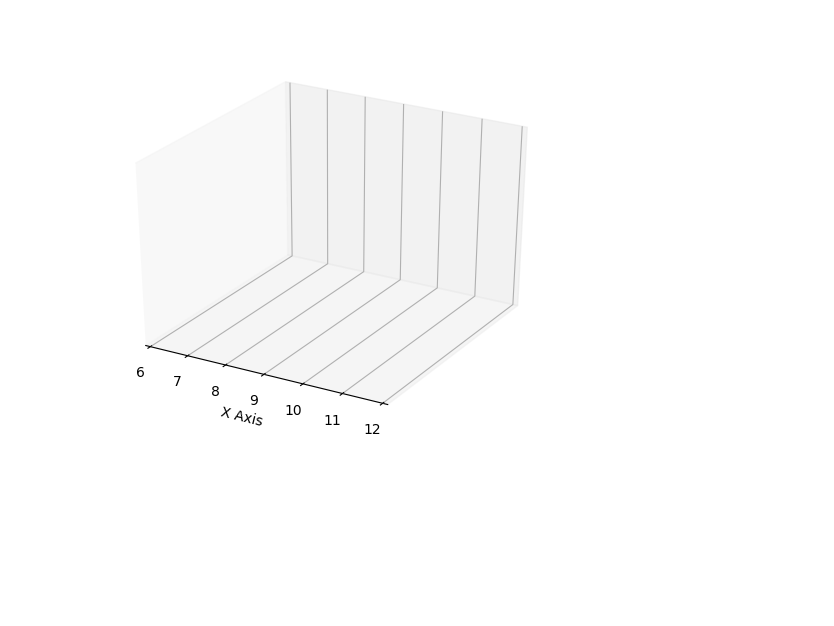

KeyboardInterrupt: 

In [76]:
## plot the vehicle's movement (add other parts as they get finished)    
print("num runs", runs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion() 

fig.show()
fig.canvas.draw()

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

for run in range(runs):
    time_of_loop = t[run]
    
    if run % 20 == 0:
        ax.clear()
        
        for rows in range(num_row_arms):
            # check if any fruit was picked at this time
            try:        
                # is the if needed when there is a try? => yup, otherwise the points appear at random times
                if fruit_removal[rows][3, index_rem[rows]] < time_of_loop:
                    # add the fruit index to be "removed"
                    index_rem[rows] += 1
            except IndexError:
                print("** Index grew faster than it should have? **")
                print("Index to remove:", index_rem[rows], "in row:", rows, "time:", time_of_loop)
                print("current value of fruit_removal:", fruit_removal[rows][3, index_rem[rows]-1])
        
        ax.scatter(fruit.sortedFruit[0,:], fruit.sortedFruit[1,:], fruit.sortedFruit[2,:], facecolors='none', edgecolors='r')
        
        for rows in range(num_row_arms):
            ax.scatter(fruit_removal[rows][0,:index_rem[rows]], fruit_removal[rows][1,:index_rem[rows]], fruit_removal[rows][2,:index_rem[rows]], c='g', marker='o')
            
        q_vehicle = [qv0[run], qv1[run]]
        dr.drawRect(q_vehicle, width_v, length_v) # try and draw the vehicle moving along the orchard
        dr.drawFrame(left_edge[run], back_edge[run], front_edge[run], a[0,0].z_edges_f)

        for rows in range(num_row_arms):
            for count in range(num_arms):
                ax.scatter(a[rows,count].qax[run], a[rows,count].qay[run], a[rows,count].qaz[run])
                # need to switch this to a cylinder
#                 dr.drawArmCylinder(center_y, center_z, arm_start, arm_end)
                xc, yc, zc = dr.drawArmCylinder(a[rows,count].qay[run], a[rows,count].qaz[run], a[rows,count].q_f[0], a[rows,count].qax[run])
                ax.plot_surface(xc, yc, zc)


        ax.set_xlim(6, 12)
        ax.set_ylim(q_v[0], end_row+3)
        
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        fig.canvas.draw()
        time.sleep(0.005)
       
    
    
fig.show()



In [346]:
print("List of the fruits that got passed over by vehicle")
print("ROW 0")
print(row_picture[0].passed_fruit)
print("ROW 1")
print(row_picture[1].passed_fruit)
print("ROW 2")
print(row_picture[2].passed_fruit)

List of the fruits that got passed over by vehicle
ROW 0
[]
ROW 1
[]
ROW 2
[]
